In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21
A = np.zeros((Nnodes,Nnodes),dtype = int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k,k+4] = 1
for k in range(4,7):  
    A[k,k+5] = 1
for k in range(9,12):  
    A[k,k+5] = 1
for k in range(14,17):  
    A[k,k+4] = 1
# horizontal springs
for k in range(3,7):
    A[k,k+1] = 1
for k in range(8,12):  
    A[k,k+1] = 1
for k in range(13,17):  
    A[k,k+1] = 1
# symmetrize
Asymm = A + np.transpose(A)
# indices of nodes on the hoop
ind_hoop = [0,3,8,13,18,19,20,17,12,7,2,1]
Nhoop = np.size(ind_hoop)
# indices of free nodes (not attached to the hoop)
ind_free = [4,5,6,9,10,11,14,15,16]
Nfree = np.size(ind_free)
# list of springs
springs = np.array(np.nonzero(A))

Nsprings = np.size(springs,axis=1)
print(springs)


[[ 0  1  2  3  4  4  5  5  6  6  8  9  9 10 10 11 11 13 14 14 15 15 16 16]
 [ 4  5  6  4  5  9  6 10  7 11  9 10 14 11 15 12 16 14 15 18 16 19 17 20]]


In [22]:
# Initialization

# Initial angles for the nodes are uniformly distributed around the range of 2*pi
# startting from theta0 and going counterclockwise
theta0 = 2*np.pi/3
theta = theta0 + np.linspace(0,2*np.pi,Nhoop+1)
theta = np.delete(theta,-1)
# Initial positions
pos = np.zeros((Nnodes,2))
pos[ind_hoop,0] = Rhoop*np.cos(theta)
pos[ind_hoop,1] = Rhoop*np.sin(theta)
pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 

# Initiallize the vector of parameters to be optimized
vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))

In [23]:
def draw_spring_system(pos,springs,R,ind_hoop,ind_free):
    # draw the hoop
    t = np.linspace(0,2*np.pi,200)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(R*np.cos(t),R*np.sin(t),linewidth = 5,color = 'red')
    # plot springs
    Nsprings = np.size(springs,axis=1)
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        plt.plot([pos[j0,0],pos[j1,0]],[pos[j0,1],pos[j1,1]],color = 'black',linewidth = 3)    
    # plot nodes
    plt.scatter(pos[ind_hoop,0],pos[ind_hoop,1],s = 300,color = 'crimson')
    plt.scatter(pos[ind_free,0],pos[ind_free,1],s = 300,color = 'black')

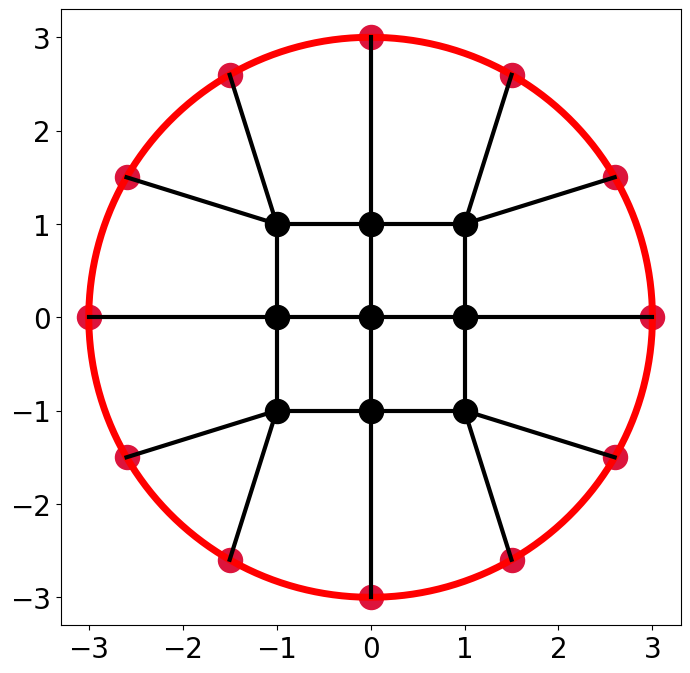

In [24]:
# Draw the initial configuration of the spring system
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)

In [25]:
def compute_gradient(theta,pos,Asymm,r0,kappa,R,ind_hoop,ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree,2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k],:])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k],:] - pos[ind,:] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        # print(k,ind,ind_hoop[k],rvec)
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k],:]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k],:] - pos[ind[j],:] # the vector from the jth adjacent node to the kth free node 
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k,:] = g_free[k,:] + (rvec_length - r0)*R*kappa*rvec/rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop,g_free[:,0],g_free[:,1]))     

def Energy(theta,pos,springs,r0,kappa):
    Nsprings = np.size(springs,axis = 1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        rvec = pos[j0,:] - pos[j1,:]
        rvec_length = np.linalg.norm(rvec)        
        E = E + kappa*(rvec_length - r0)**2
    E = E*0.5
    return E
    

In [26]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    # positions of the free nodes
    pos[ind_free,0] = vec[Nhoop:Nnodes]
    pos[ind_free,1] = vec[Nnodes:] 
    return theta,pos

def gradient(vec):
    theta,pos = vec_to_pos(vec) 
    return compute_gradient(theta,pos,Asymm,r0,kappa,Rhoop,ind_hoop,ind_free)

def func(vec):
    theta,pos = vec_to_pos(vec) 
    return Energy(theta,pos,springs,r0,kappa)


Iteration 0: Energy = 3.819636, Gradient Nrom = 9.4333e+00
Iteration 50: Energy = 1.563704, Gradient Nrom = 4.1852e-01
Iteration 100: Energy = 1.520152, Gradient Nrom = 2.2412e-01
Iteration 150: Energy = 1.503992, Gradient Nrom = 1.4137e-01
Iteration 200: Energy = 1.497363, Gradient Nrom = 9.1283e-02
Iteration 250: Energy = 1.494560, Gradient Nrom = 5.9552e-02
Iteration 300: Energy = 1.493360, Gradient Nrom = 3.9022e-02
Iteration 350: Energy = 1.492844, Gradient Nrom = 2.5618e-02
Iteration 400: Energy = 1.492621, Gradient Nrom = 1.6832e-02
Iteration 450: Energy = 1.492525, Gradient Nrom = 1.1063e-02
Iteration 500: Energy = 1.492483, Gradient Nrom = 7.2724e-03
Iteration 550: Energy = 1.492465, Gradient Nrom = 4.7809e-03
Iteration 600: Energy = 1.492457, Gradient Nrom = 3.1431e-03
Iteration 650: Energy = 1.492454, Gradient Nrom = 2.0664e-03
Iteration 700: Energy = 1.492453, Gradient Nrom = 1.3585e-03
Iteration 750: Energy = 1.492452, Gradient Nrom = 8.9314e-04
Iteration 800: Energy = 1.4

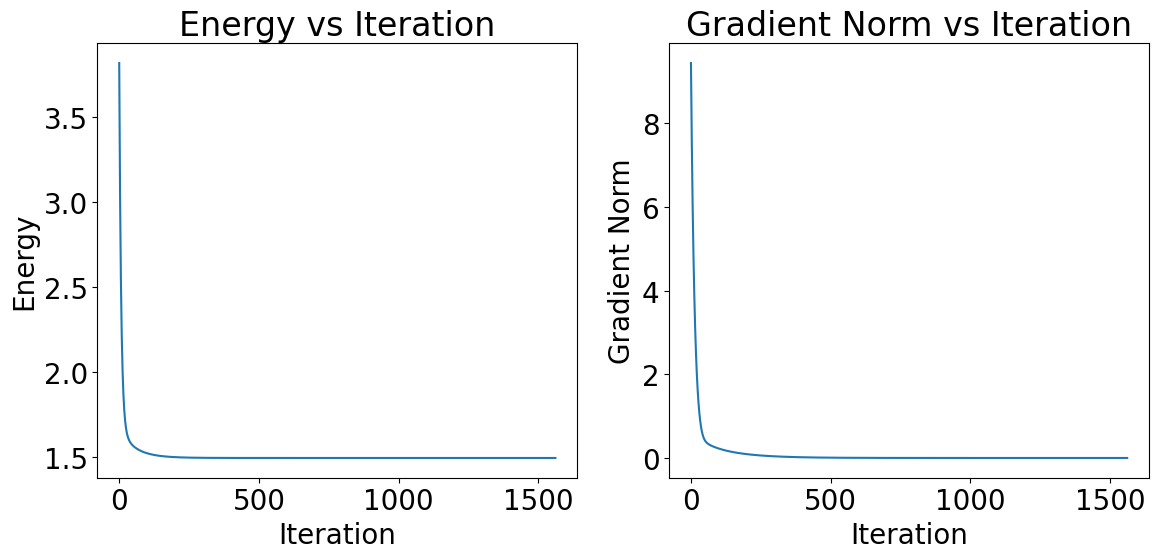

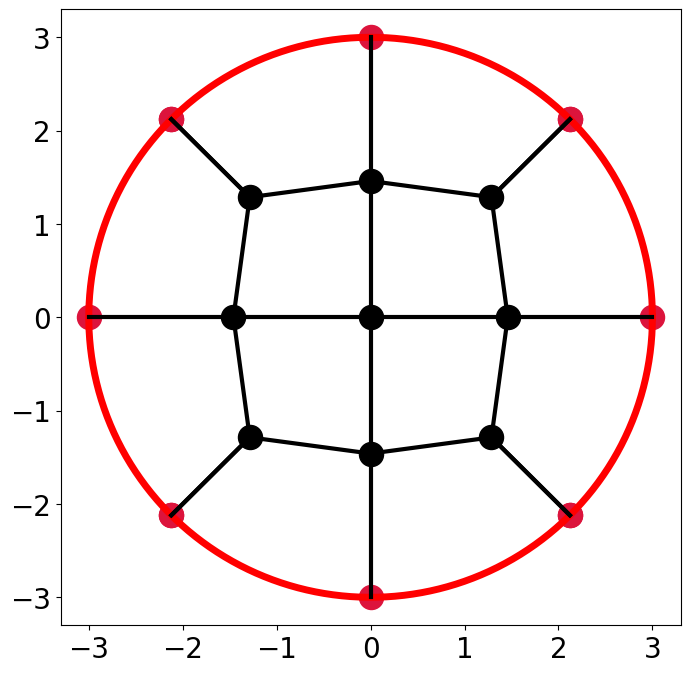

In [ ]:
def gradient_descent(vec, func, gradient, learning_rate=0.01, max_iter=2000, tol=1e-6):

    energy_list = []  
    grad_norm_list = []  

    for i in range(max_iter):
        # Compute energy and gradient
        E = func(vec)
        grad = gradient(vec)
        
        
        energy_list.append(E)
        grad_norm = np.linalg.norm(grad)
        grad_norm_list.append(grad_norm)

        
        if grad_norm < tol:
            print(f"Gradient descent converges on iteration {i+1}: Gradient Norm = {grad_norm:.4e}")
            break
        
        # Update parameters
        vec -= learning_rate * grad
        
        # Print information every 50 iterations
        if i % 50 == 0:
            print(f"Iteration {i}: Energy = {E:.6f}, Gradient Nrom = {grad_norm:.4e}")

    return vec, energy_list, grad_norm_list


theta0 = 2 * np.pi / 3
theta = theta0 + np.linspace(0, 2 * np.pi, Nhoop + 1)
theta = np.delete(theta, -1)
pos = np.zeros((Nnodes, 2))
pos[ind_hoop, 0] = Rhoop * np.cos(theta)
pos[ind_hoop, 1] = Rhoop * np.sin(theta)
pos[ind_free, 0] = np.array([-1., 0., 1., -1., 0., 1., -1., 0., 1.])
pos[ind_free, 1] = np.array([1., 1., 1., 0., 0., 0., -1., -1., -1.])
vec = np.concatenate((theta, pos[ind_free, 0], pos[ind_free, 1]))

# Perform gradient descent
optimal_vec, energy_list, grad_norm_list = gradient_descent(vec, func, gradient)

# Final results
theta_final, pos_final = vec_to_pos(optimal_vec)
print("\nfinal node position (x, y)：")
for i, (x, y) in enumerate(pos_final):
    print(f"Node {i}: ({x:.4f}, {y:.4f})")

final_energy = func(optimal_vec)
final_grad_norm = np.linalg.norm(gradient(optimal_vec))
print(f"\nFinal energy value: {final_energy:.6f}")
print(f"Final gradient norm: {final_grad_norm:.4e}")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(energy_list)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy vs Iteration")

plt.subplot(1, 2, 2)
plt.plot(grad_norm_list)
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm vs Iteration")
plt.tight_layout()
plt.show()

# Draw the final configuration of the spring system
theta_final, pos_final = vec_to_pos(optimal_vec)
draw_spring_system(pos_final, springs, Rhoop, ind_hoop, ind_free)


Initial energy: 3.819636, gradient norm: 9.4333e+00
Iteration 0: Energy = 3.044465, gradient norm = 7.9098e+00
Iteration 50: Energy = 1.492451, gradient norm = 1.9663e-06
The conjugate gradient method converges on iteration 57: gradient norm = 9.3972e-07

final node position (x, y)：
Node 0: (-2.1213, 2.1213)
Node 1: (0.0000, 3.0000)
Node 2: (2.1213, 2.1213)
Node 3: (-2.1213, 2.1213)
Node 4: (-1.2864, 1.2864)
Node 5: (0.0000, 1.4601)
Node 6: (1.2864, 1.2864)
Node 7: (2.1213, 2.1213)
Node 8: (-3.0000, 0.0000)
Node 9: (-1.4601, 0.0000)
Node 10: (0.0000, -0.0000)
Node 11: (1.4601, 0.0000)
Node 12: (3.0000, -0.0000)
Node 13: (-2.1213, -2.1213)
Node 14: (-1.2864, -1.2864)
Node 15: (-0.0000, -1.4601)
Node 16: (1.2864, -1.2864)
Node 17: (2.1213, -2.1213)
Node 18: (-2.1213, -2.1213)
Node 19: (-0.0000, -3.0000)
Node 20: (2.1213, -2.1213)

Final energy value: 1.492451
Final gradient norm: 9.3972e-07


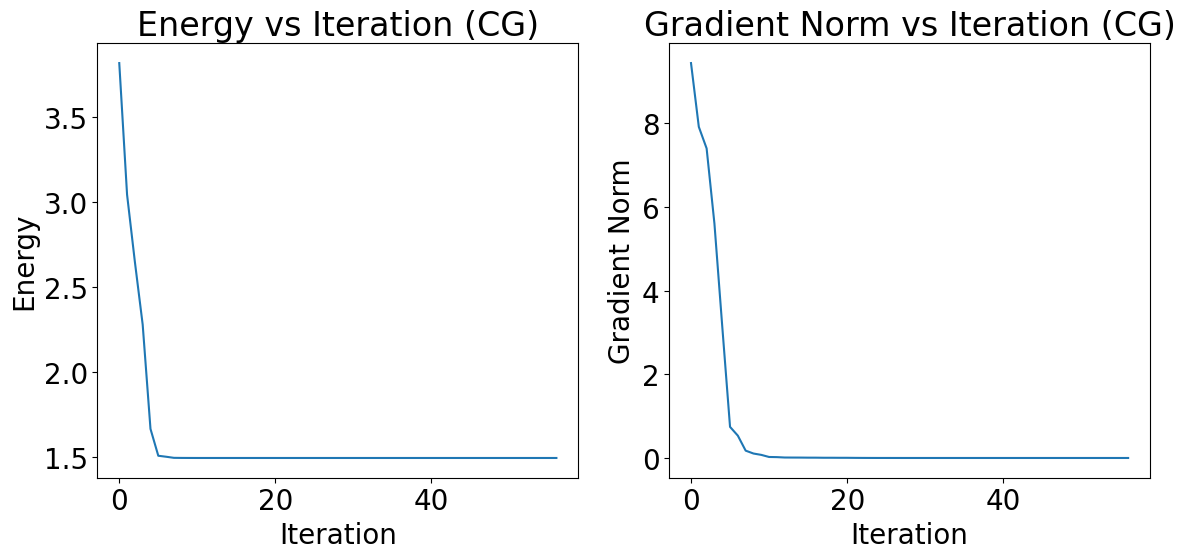

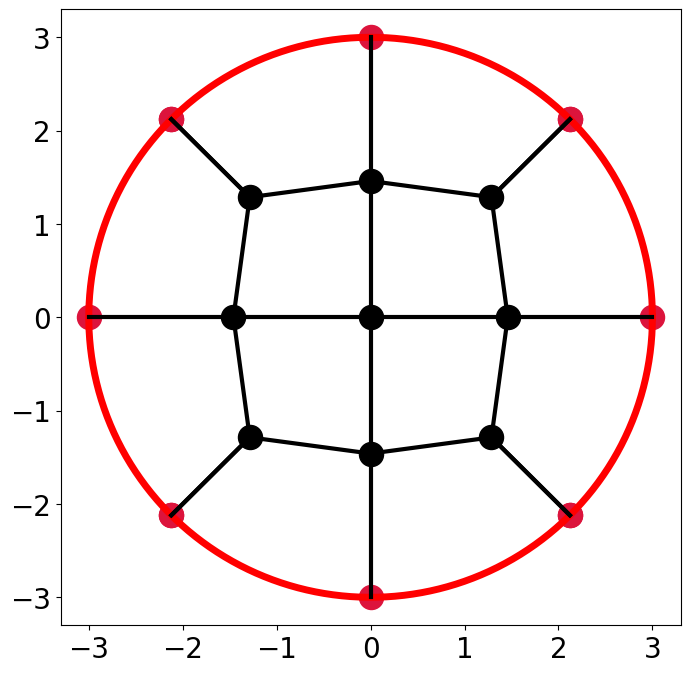

In [38]:
def conjugate_gradient(vec, func, gradient, max_iter=2000, tol=1e-6):
 
    energy_list = []  
    grad_norm_list = []  

    # Initialize parameters
    g = gradient(vec)  # Initial gradient
    d = -g  # Initial search direction
    grad_norm = np.linalg.norm(g)  # Initial gradient norm
    energy = func(vec)
    
    energy_list.append(energy)
    grad_norm_list.append(grad_norm)

    print(f"Initial energy: {energy:.6f}, gradient norm: {grad_norm:.4e}")

    for k in range(max_iter):
        if grad_norm < tol:
            print(f"The conjugate gradient method converges on iteration {k+1}: gradient norm = {grad_norm:.4e}")
            break

        # Line search: determine the step size alpha
        alpha_k = line_search(vec, func, gradient, d)

        # Update parameters
        vec = vec + alpha_k * d

        # Compute new gradient and gradient norm
        g_new = gradient(vec)
        grad_norm_new = np.linalg.norm(g_new)

        energy = func(vec)
        energy_list.append(energy)
        grad_norm_list.append(grad_norm_new)

        # Compute beta_k  (Fletcher-Reeves formula)
        beta_k = (grad_norm_new ** 2) / (grad_norm ** 2)

        # Update search direction
        d = -g_new + beta_k * d

        # Update gradient and gradient norm
        g = g_new
        grad_norm = grad_norm_new

        # Print information every 50 iterations
        if k % 50 == 0:
            print(f"Iteration {k}: Energy = {energy:.6f}, gradient norm = {grad_norm:.4e}")


    return vec, energy_list, grad_norm_list

def line_search(vec, func, gradient, direction, alpha_init=1.0, c=0.005, tau=0.5):
 
    alpha = alpha_init
    phi_0 = func(vec)
    g = gradient(vec)
    while func(vec + alpha * direction) > phi_0 + c * alpha * np.dot(g, direction):
        alpha *= tau
    return alpha


theta0 = 2 * np.pi / 3
theta = theta0 + np.linspace(0, 2 * np.pi, Nhoop + 1)
theta = np.delete(theta, -1)
pos = np.zeros((Nnodes, 2))
pos[ind_hoop, 0] = Rhoop * np.cos(theta)
pos[ind_hoop, 1] = Rhoop * np.sin(theta)
pos[ind_free, 0] = np.array([-1., 0., 1., -1., 0., 1., -1., 0., 1.])
pos[ind_free, 1] = np.array([1., 1., 1., 0., 0., 0., -1., -1., -1.])
vec = np.concatenate((theta, pos[ind_free, 0], pos[ind_free, 1]))

# Perform conjugate gradient
optimal_vec1, energy_list1, grad_norm_list1 = conjugate_gradient(vec, func, gradient)

# Final results
theta_final1, pos_final1= vec_to_pos(optimal_vec1)
print("\nfinal node position (x, y)：")
for i, (x, y) in enumerate(pos_final1):
    print(f"Node {i}: ({x:.4f}, {y:.4f})")

final_energy = func(optimal_vec1)
final_grad_norm = np.linalg.norm(gradient(optimal_vec1))
print(f"\nFinal energy value: {final_energy:.6f}")
print(f"Final gradient norm: {final_grad_norm:.4e}")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(energy_list1)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy vs Iteration (CG)")

plt.subplot(1, 2, 2)
plt.plot(grad_norm_list1)
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm vs Iteration (CG)")
plt.tight_layout()
plt.show()

# Draw the final configuration of the spring system
theta_final, pos_final = vec_to_pos(optimal_vec)
draw_spring_system(pos_final, springs, Rhoop, ind_hoop, ind_free)
